In [33]:
import tensorflow as tf
# print('import tf', tf.__version__)

import os,pickle
import time
import datetime
from imp import reload
from matplotlib import pyplot as plt
import numpy as np
import sys
from units.globals import DEBUG
from units.globals import DEBUG,NEWPATH,N_CPU
import argparse

from units.base import visualize,generate_images,show
from units.dataloader import load_np_data
from sklearn.model_selection import train_test_split

In [34]:
argv=["ipykernel_launcher.py","-b","1","-e","200","-m","pet_cycgan"]

In [35]:
sys.argv=["ipykernel_launcher.py","-b","4","-e","200","-m","logs/54612"]

In [36]:
parser=argparse.ArgumentParser(description="cyc_GAN_model")
parser.add_argument("-l","--lamda",type=float,default=10, help="set cycle-consistency lamda value")
parser.add_argument("-b","--batch_size",type=int,default=1, help="set batch size")
parser.add_argument("-e","--epoches",type=int,default=200, help="set epoches")
parser.add_argument("-m","--model_path",default=None, help="set pretrained model path")
parser.add_argument("-a","--argument",type=bool,default=False, help="whether use argument")
args = parser.parse_args()

LAMDA=args.lamda
BATCH_SIZE=args.batch_size
EPOCHES=args.epoches
MODEL_PATH=args.model_path
ARGU=args.argument


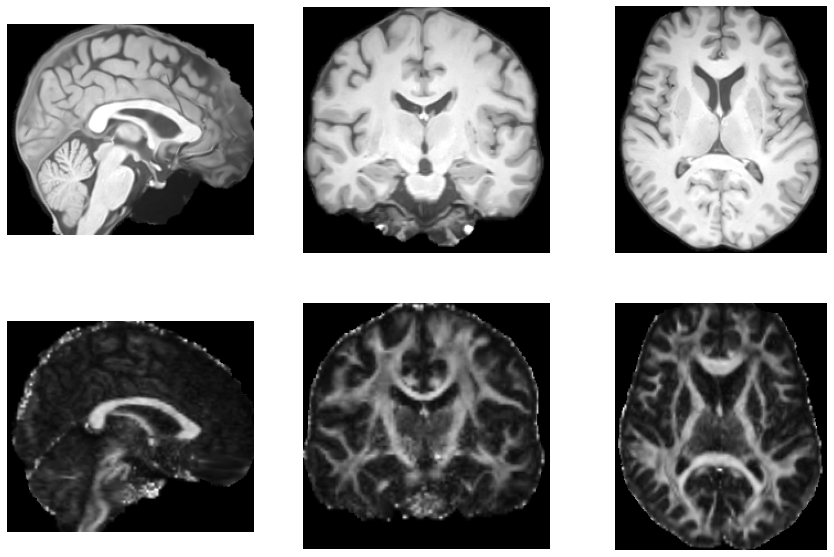

In [37]:
# reload(GAN)

data=[f"{NEWPATH}/{img}"for img in os.listdir(NEWPATH)]

demo=np.load(data[3])
t1,fa=demo["T1"],demo["FA"]
# t1[fa==0]=0
visualize([t1,fa],save_path="demo/paired.png")

In [38]:
p=np.array([demo[md.decode()if type(md)!=str else md]for md in ["T1","FA","WM"]])


(128, 128, 128, 1)


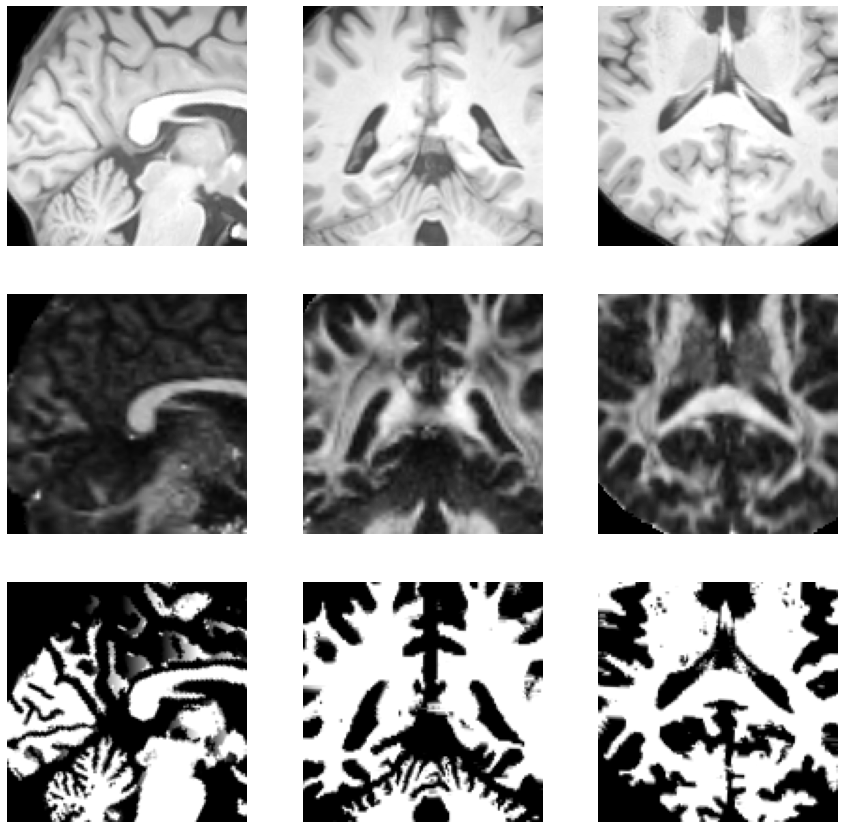

In [41]:
from units.dataloader import load_np_data
print(load_np_data(data[3],load_mods=["T1","FA","WM"],argu=False)[0].shape)
visualize([img[...,0] for img in load_np_data(data[3],load_mods=["T1","FA","WM"],argu=False)])

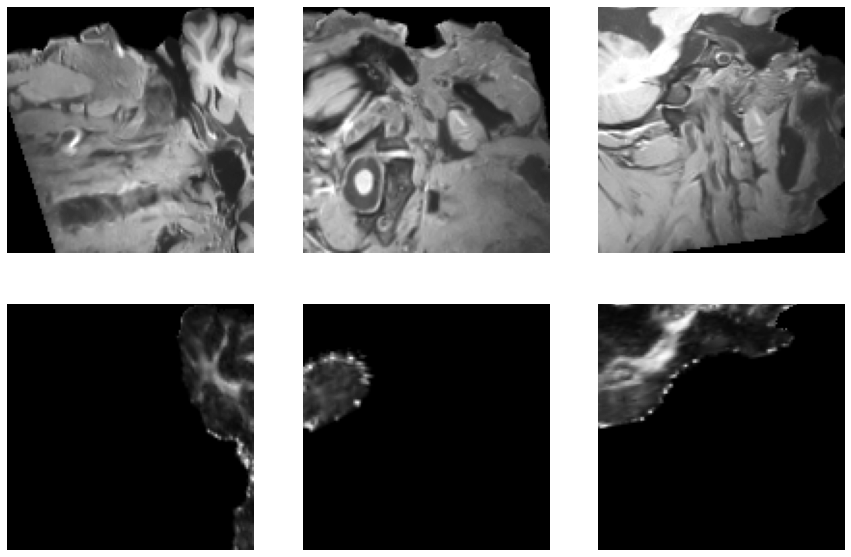

In [29]:
from units.dataloader import load_np_data

t1_arg,fa_arg=load_np_data(data[0],["T1","FA"],ARGU)
# print(t1_arg.shape)
# t1_arg,fa_arg=load_image_train(t1_arg,fa_arg)#,[Rotation3D(max_rate=np.pi/2)])
visualize([t1_arg[...,0],fa_arg[...,0]])
np.save("demo/t1_arg",t1_arg)
np.save("demo/fa_arg",fa_arg)

In [30]:
NEWPATH="datasets/brainmap/npdata"
data=[f"{NEWPATH}/{img}"for img in os.listdir(NEWPATH)]
train_val,test=train_test_split(
    data,test_size=0.1,random_state=1919810
)
train,val=train_test_split(
    train_val,test_size=0.1,random_state=114514
)
show(f"Train len: {len(train)}")
show(f"Val len: {len(val)}")
show(f"Test len: {len(test)}")

Train len: 9
Val len: 2
Test len: 2


In [31]:
# The facade training set consist of 400 images

BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
# st_range=np.array((227, 272, 227))-np.array((128,128,128))

train_load=lambda filename:tf.numpy_function(func=load_np_data,inp=[filename,["T1","FA"],ARGU],Tout=(tf.float32,tf.float32))
test_load=lambda filename:tf.numpy_function(func=load_np_data,inp=[filename,["T1","FA"],False],Tout=(tf.float32,tf.float32))

def get_train_ds(train):
    # train_dataset=[]
    # for t in tqdm(train):
        # train_dataset.append(load_image_train(t))
    # train_dataset=np.array(train_dataset)
    # train_dataset = list(map(load_image_train,train))
    
    train_dataset = tf.data.Dataset.from_tensor_slices(train)
    # print(train_dataset)
    # train_dataset=load_image_train(train)
    train_dataset = train_dataset.map(map_func=train_load,num_parallel_calls=N_CPU)
    train_dataset = train_dataset.shuffle(BUFFER_SIZE,seed=114514)
    train_dataset = train_dataset.batch(BATCH_SIZE,num_parallel_calls=N_CPU)
    return train_dataset
# train_dataset=train_dataset.map(lambda x:tf.numpy_function(func=upper_case_fn,inp=[x],Tout=(tf.float64,tf.float64)))

def get_test_ds(test):
    # test_dataset=[]
    # for i in range(8):test_dataset+=[load_image_test(test_dir)for test_dir in test]
    # iplist,relist=[],[]
    # for input,real in test_dataset:
    #     iplist.append(input)
    #     relist.append(real)
    test_dataset = tf.data.Dataset.from_tensor_slices(test)
    test_dataset = test_dataset.map(map_func=test_load,num_parallel_calls=N_CPU)
    # test_dataset = test_dataset.map(lambda x:tf.numpy_function(func=load_image_test,inp=[x],Tout=(tf.float32,tf.float32)),num_parallel_calls=16,deterministic=False)
    # test_dataset = test_dataset.map(lambda x:tf.numpy_function(func=load_image_test,inp=[x],Tout=(tf.float32,tf.float32)),num_parallel_calls=tf.data.AUTOTUNE,deterministic=False)
    test_dataset = test_dataset.batch(BATCH_SIZE,num_parallel_calls=N_CPU)
    return test_dataset

train_ds,val_ds,test_ds=get_train_ds(train),get_test_ds(val),get_test_ds(test)

In [32]:
for i,j in train_ds:
    print(i.shape)

(4, 128, 128, 128, 1)
(4, 128, 128, 128, 1)
(1, 128, 128, 128, 1)


In [ ]:
from GAN.model import Pix2pix
from units.base import generate_images,visualize

tip,fip=t1_arg,fa_arg
p2pgan=Pix2pix(tip.shape,example_data=[tip,fip])
G,D=p2pgan.G,p2pgan.D
generate_images(G,tip[...,0],fip[...,0])
print(p2pgan.test_step(tip[tf.newaxis,...],fip[tf.newaxis,...]))

In [ ]:
tot_step=len(train_ds)*200
h=p2pgan.train(train_ds,val_ds,steps=tot_step)
with open(f"{p2pgan.log_dir}/training_log.pic","wb") as f:
    pickle.dump(h,f)
from units.base import show_process
show_process(h["train"],labels=p2pgan.outputs ,save_path=f"{p2pgan.log_dir}/train_process")
show_process(h["valid"],labels=p2pgan.outputs, save_path=f"{p2pgan.log_dir}/valid_process")

In [20]:
np.min(fip)

0.0

(128, 128, 128, 1)


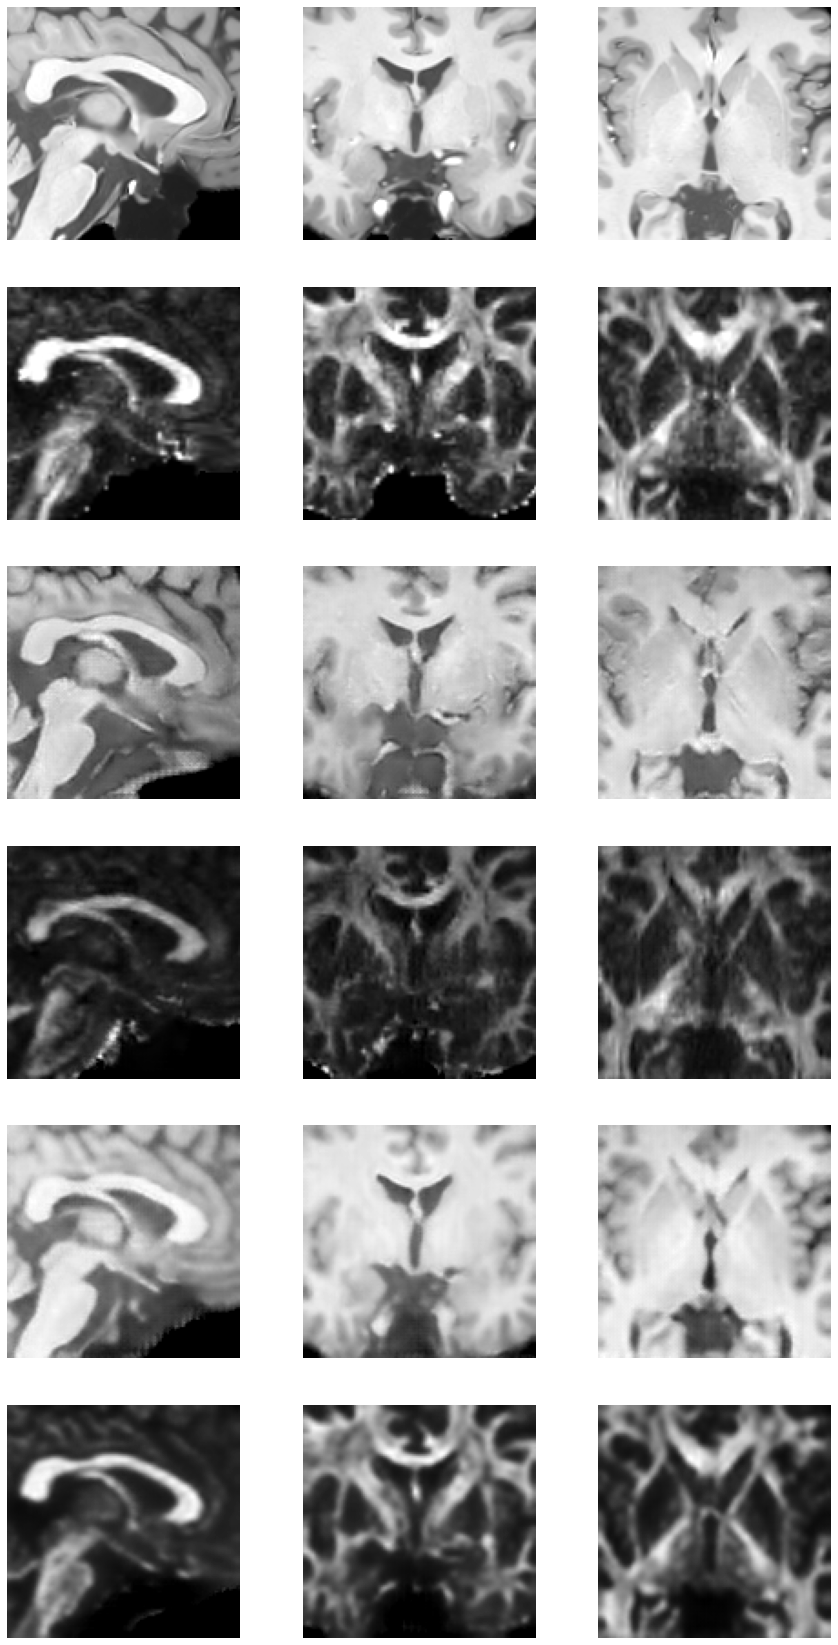

ValueError: image_true has intensity values outside the range expected for its data type. Please manually specify the data_range.

In [16]:
# del Generator
from pet_cycgan import Cycgan_pet
from units.base import cyc_generate_images,generate_images,visualize

tip,fip=t1_arg,fa_arg

print(tip.shape)
# tip,fip=t1_arg[0:128,0:128,0:128],fa_arg[0:128,0:128,0:128]
cycgan=Cycgan_pet(tip.shape,lamda=LAMDA,example_data=[tip,fip])
if MODEL_PATH is not None:
    cycgan.load_model(MODEL_PATH)
cycgan.generate_images([tip[...,0],fip[...,0]])

T1_metric,FA_metric=cycgan.eval_result(test_ds)
print("T1_metric:",T1_metric)
print("FA_metric:",FA_metric)

# print(cycgan.test_step(tip[tf.newaxis,...],fip[tf.newaxis,...]))

Time taken for 1 dataload: 2.44 sec

Step 1/1800
G1_loss : 1.705787
G2_loss : 1.551225
DA_loss : 1.011732
DB_loss : 1.002338
cyc_loss_A : 0.530297
cyc_loss_B : 0.299579
tot_cyc_loss : 0.829876

Time taken for 1 steps: 197.84 sec

Val_step: 0/100
Train loss:
G1_loss : 1.705787
G2_loss : 1.551225
DA_loss : 1.011732
DB_loss : 1.002338
cyc_loss_A : 0.530297
cyc_loss_B : 0.299579
tot_cyc_loss : 0.829876

Val loss:
G1_loss : 1.491934
G2_loss : 1.750250
DA_loss : 0.921359
DB_loss : 0.885153
cyc_loss_A : 0.540862
cyc_loss_B : 0.304528
tot_cyc_loss : 0.845390



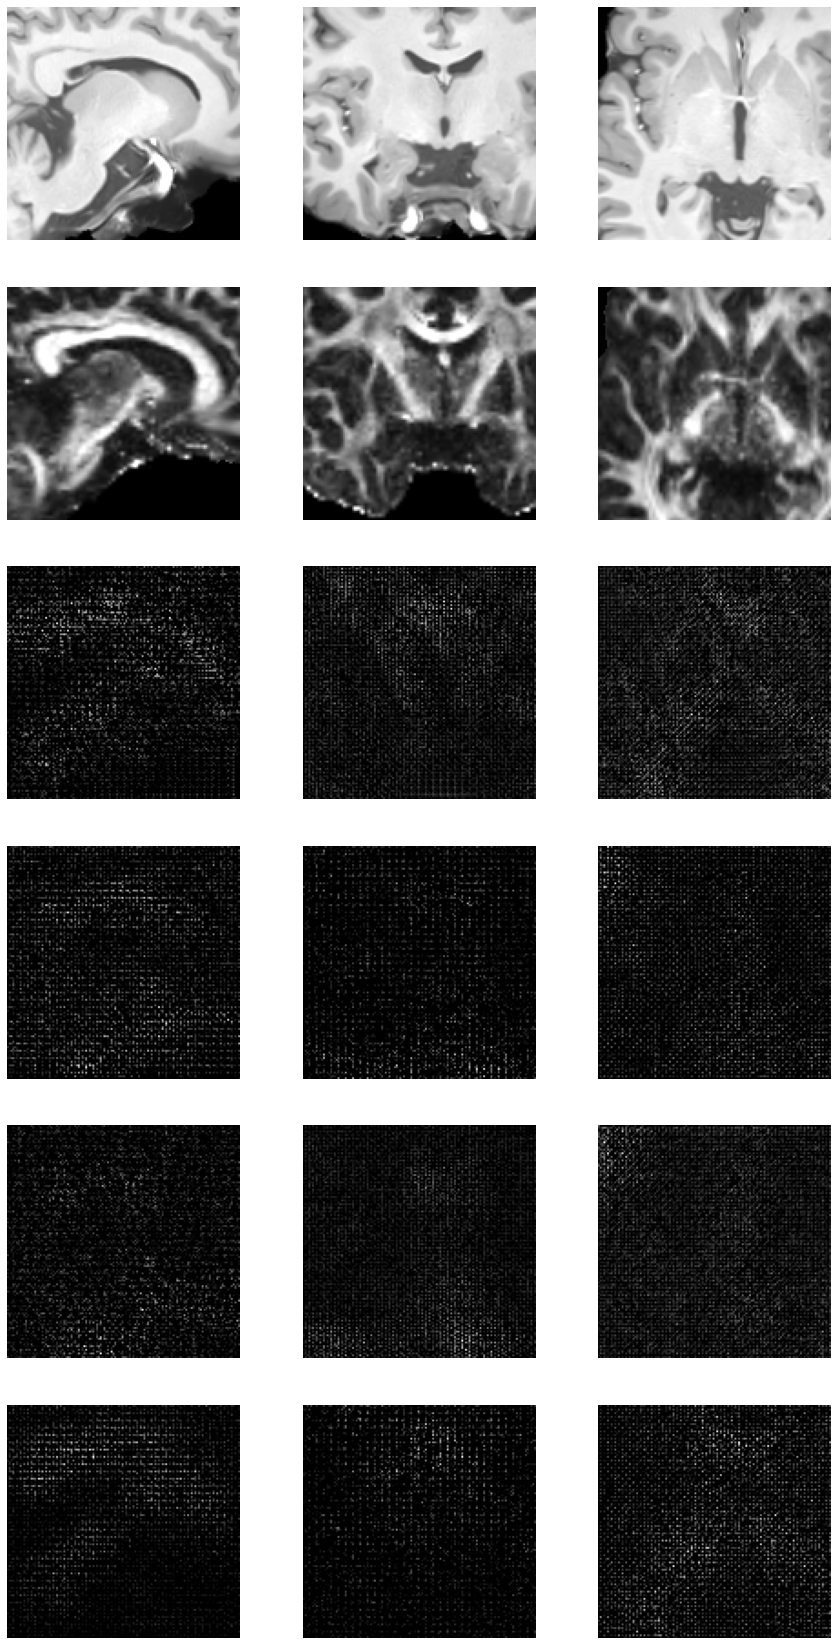

Validation loss decresaed from inf to 3.2422. Models' weights are now saved.
Time taken for 1 dataload: 0.01 sec

Step 2/1800
G1_loss : 1.586292
G2_loss : 1.803463
DA_loss : 0.812408
DB_loss : 0.938736
cyc_loss_A : 0.598468
cyc_loss_B : 0.318317
tot_cyc_loss : 0.916785

Time taken for 1 steps: 182.25 sec

Time taken for 1 dataload: 0.02 sec

Step 3/1800


KeyboardInterrupt: 

In [8]:
tot_step=len(train_ds)*EPOCHES
h=cycgan.train(train_ds,val_ds,steps=tot_step)
with open(f"{cycgan.log_dir}/training_log.pic","wb") as f:
    pickle.dump(h,f)
from units.base import show_process
show_process(h["train"],labels=cycgan.outputs ,save_path=f"{cycgan.log_dir}/train_process")
show_process(h["valid"],labels=cycgan.outputs, save_path=f"{cycgan.log_dir}/valid_process")

### END

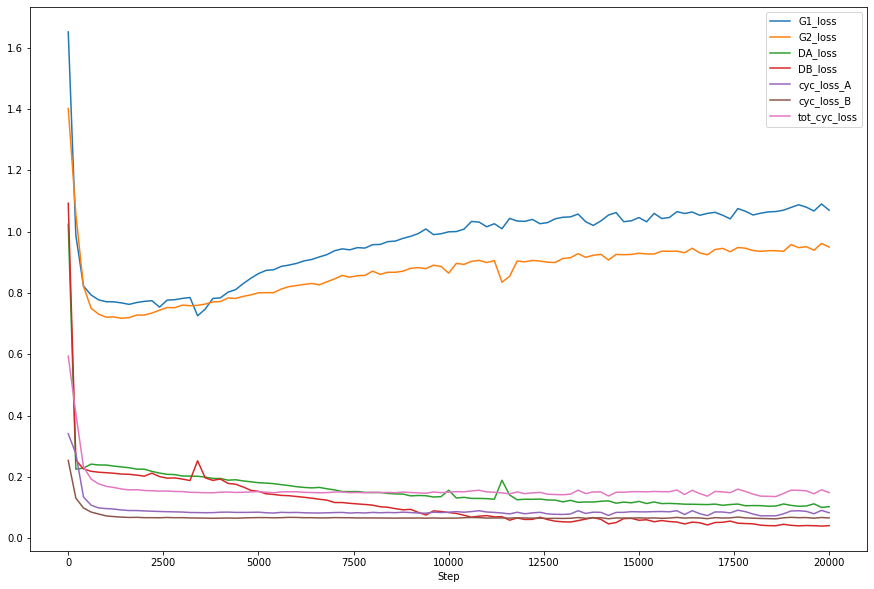

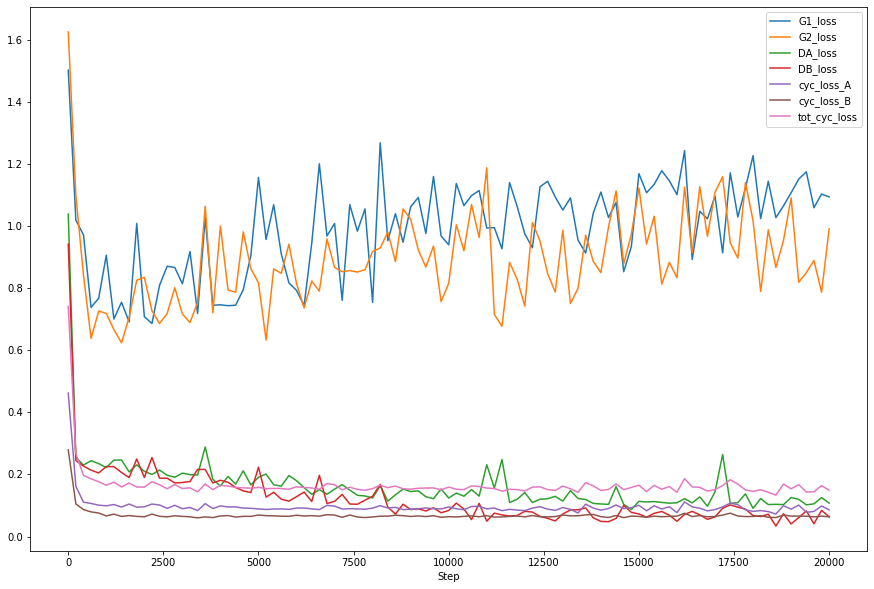

In [13]:
from units.base import show_process
import pickle
with open(f"logs/lamda120220411-005333/training_log.pic","rb") as f:
    h=pickle.load(f)
show_process(h["train"],labels=cycgan.outputs)
show_process(h["valid"],labels=cycgan.outputs)

In [ ]:
import pickle
fin_log_dir="logs/lamda120220409-160103"
# fin_log_dir="train_gan.job"
with open(f"{fin_log_dir}/training_log.pic","rb") as f:
    t=pickle.load(f)


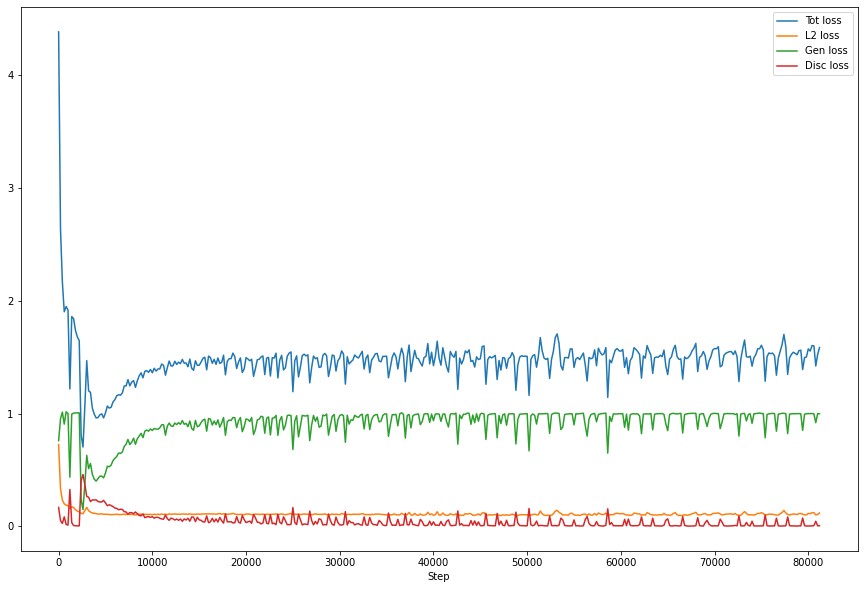

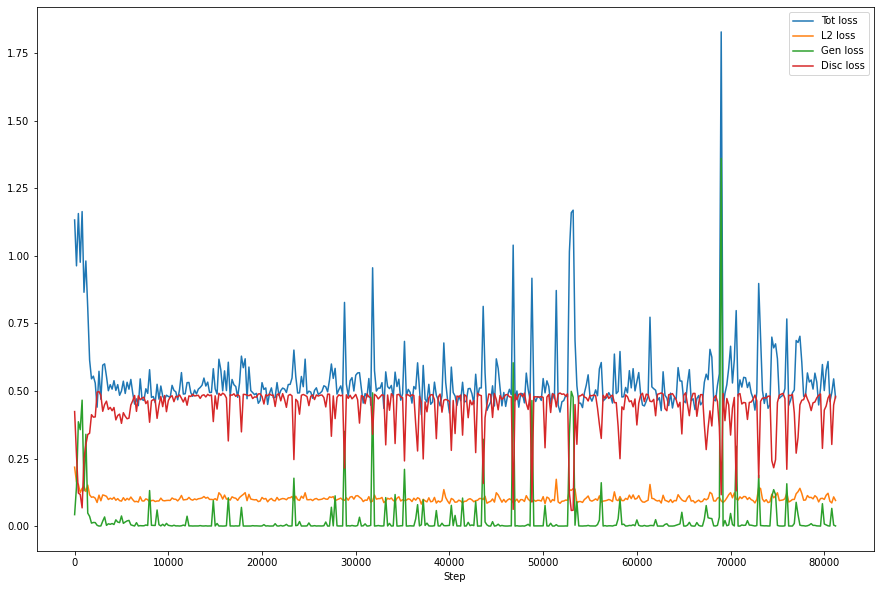

In [ ]:
import matplotlib.pyplot as plt
def show_train_result(pic_data,save_path=None):
    plt.figure(figsize=(15,10))
    x=range(0,len(pic_data)*200,200)
    # plt.yscale('log')
    plt.xlabel("Step")
    plt.plot(x,pic_data,label=["Tot loss","L2 loss","Gen loss","Disc loss"])
    plt.legend()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()
# plt.plot(x,t["val"],label="GAN loss")
show_train_result(t["train"],fin_log_dir+"train_result")
show_train_result(t["valid"],fin_log_dir+"valid_result")

In [ ]:
from GAN.model import Generator,Discriminator
# reload(GAN.model)
G = Generator()
D=Discriminator()

# G.summary(line_length=120)
D.summary(line_length=120)

Model: "Discriminator"
________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
input_image (InputLayer)               [(None, 128, 128, 128, 1)] 0                                                     
________________________________________________________________________________________________________________________
target_image (InputLayer)              [(None, 128, 128, 128, 1)] 0                                                     
________________________________________________________________________________________________________________________
concatenate_31 (Concatenate)           (None, 128, 128, 128, 2)   0             input_image[0][0]                       
                                                                                target_image[0][0]                      
_________

In [ ]:
#try tensor.map
train_dataset = tf.data.Dataset.from_tensor_slices(train)
# d = tf.data.Dataset.from_tensor_slices(['hello', 'world'])
def upper_case_fn(t: np.ndarray):
    return t.decode('utf-8')+"1",t.decode('utf-8')+"2"
# d = d.map(lambda x: tf.numpy_function(func=upper_case_fn,
        #   inp=[x], Tout=tf.string))
# list(d.as_numpy_iterator())
train_dataset=train_dataset.map(lambda x:tf.numpy_function(func=upper_case_fn,inp=[x],Tout=(tf.float64,tf.float64)))
# train_dataset=train_dataset.map(lambda x:tf.strings.as_string(x)+"2")
list(train_dataset.as_numpy_iterator())
# len(train_dataset.map(np.array))
# for i in train_dataset:
    # print()#.numpy())


In [ ]:
from numpy.random import randint
d = tf.data.Dataset.from_tensor_slices(['hello', 'world'])
def upper_case_fn(t: np.ndarray):
  return (t.decode('utf-8')+str(randint(10))).upper()
d = d.map(lambda x: tf.numpy_function(func=upper_case_fn,
          inp=[x], Tout=tf.string),num_parallel_calls=tf.data.AUTOTUNE,deterministic=False)
list(d.repeat().take(10).as_numpy_iterator())
# list(d.as_numpy_iterator())

[b'HELLO3',
 b'WORLD3',
 b'HELLO9',
 b'WORLD2',
 b'HELLO9',
 b'WORLD5',
 b'HELLO4',
 b'WORLD2',
 b'HELLO8',
 b'WORLD2']